# Project 2B
In this part B, we set up road network of the GT campus with [world.csv](https ://bitbucket.org/gtcx4230s p15/gt-world).Some assumptions made in this simulator is that people follow regular traffic rules in that people only drive in the direction of the street. Cars may not make a "U turn" when driving on a particular street; however, the driver may choose to drive back the road which (s)he came from if a street is 2 way. The capacity of the road is calculated using the real life GT campus width / # of cells horizontally * the street length in unit cells. A car may not choose to drive back when the driver has reached an exit. 

We instantiate the simulator with the road network of nodes. Both parking and streets are nodes. Each node has a start and end point which indicates the direction of the street; each node has children nodes which indicates the road connections. If a street is 2 way, a new node with opposite direction will be generated to accout for the counter flow. 
We also implement three kinds of random number generators.
In part C, we will use Priority Queue to handle all the events. We defined 4 types of events: 


1.**In Parking**: The initial event for all cars.

2.**On Street**

3.**At Intersection**

4.**Exit**

For a given event, a time will be associated with it. The time indicates when this event will be processed. For event 1 and 2, the simulator will check if the car can in fact complete the action and move on to the next action. An action can be completed if there are no other cars in front this car. If the car cannot leave this street and arrive at an intersection or leave the parking lot, a new event will be generated with a later time associated with the same car for the same action. This can model a traffic backup correctly in that it's not known how long it takes to complete this action of leaving the parking lot or leaving this street. We will not only use random numbers for dertermining time interval but we will also use them for handling intersection event.

In [5]:
DEBUG = 1
PARKING_NODE_COLOR = 'b'
EXIT_NODE_COLOR = 'r'
STREET_NODE_COLOR = 'g'

#Simulation parameter
UNIT_LENGTH = math.ceil(5000/738)   #ft
AVERAGE_CAR_SPACE_LENGTH = 20 #ft

In [3]:
import types
from copy import deepcopy
from random import random, seed, gauss
from math import log

def getDirection(node):
    (x1,y1) = node.start
    (x2,y2) = node.end
    if((x2-x1) == 0):
        if(y2 > y1):
            deg = 90
        else:
            deg = 270
    elif((y2-y1) == 0):
        if(x2>x1):
            deg = 0
        else:
            deg = 180
    else:
        deg = math.atan((y2-y1)/(x2-x1)) / math.pi * 180
        if(deg < 0):
            deg += 360
        if(y2<y1 and x2<x1):
            deg += 180
        if(y2>y1 and x2<x1):
            deg -= 180
    return deg

def genRandom(l, type='exponential'):
    if(type == 'exponential'):
        return -l*log(1-random())
    elif(type == 'uniform'):
        return random()
    elif(type == 'normal'):
        return gauss(0,1)
    
def genID(N=5):
    ''.join(random.SystemRandom().choice(string.ascii_uppercase + string.digits) for _ in range(N))

#Parking, streets are all nodes.
#Attributes:
#   type: Either 0/1 0 -> street  1-> parking
#   start, end: tuple
#   capactiy: integer
#   comment: string
#   id: assigned id for easy identification
#   exit: whether this node is a designated evacuation location 
#Each node is connected to the nodes that have start as this node's start.
class Node:
    TYPE_STREET = 0
    TYPE_PARKING = 1
    def __init__(self, type, start, end, capacity, id, comment='', exit=False):
        assert(type == Node.TYPE_PARKING or type == Node.TYPE_STREET)
        self.type = type
        assert(len(start) == 2)
        self.start = start

        assert(len(end) == 2)
        self.end = end

        assert(start != end)
        assert(capacity > 0)
        self.capacity = capacity
        self.comment = comment
        self.id = id
        self.exit = exit
        self.__cars = []
        self.__children = []

    def enterCar(self, car):
        assert(self.canEnterCar())
        assert(isinstance(car, Car))
        self.__cars.append(car)
        car.setCurrentNode(self)

    def exitCar(self):
        return self.__cars.pop()
    def carCount(self):
        return len(self.__cars)
    def canEnterCar(self):
        return(self.carCount() < self.capacity)
    def setExit(self, isExit):
        self.exit = isExit
    def addChildNode(self, node):
        assert(isinstance(node, Node))
        self.__children.append(node)
    def getChildren(self):
        return deepcopy(self.__children)
    def getDirection(self):
        return getDirection(self)
    
    #To string to be used by print()
    def __repr__(self):
        if(self.type == Node.TYPE_STREET):
            nodeType = "\nStreet"
        else:
            nodeType = "\nParking"
        string = nodeType + " ID: " + str(self.id)
        if(self.exit):
            string += " is an exit. "
        if(DEBUG):        
            string += " From " + str(self.start) + " To " + str(self.end) \
                + " Capacity: " + str(self.capacity) + " Current: " + str(self.carCount()) + "\n"
            
            i = 1
            for car in self.__cars:
                string += "\t" + str(i) + ": " + str(car) + "\n"
                i += 1
        if(len(self.__children) > 0):
            string += "Children: \n"
            for child in self.__children:
                if(child.type == Node.TYPE_STREET):
                    nodeType = "\tStreet"
                else:
                    nodeType = "\tParking"
                string += nodeType + " ID: " + str(child.id) + "\n"
        return string

#Car object to keep track of the car's current location and its path.
class Car:
    def __init__(self, initial):
        assert(isinstance(initial, Node))
        assert((initial.type == Node.TYPE_PARKING))
        self.__currentNode = initial
        self.__path = [initial]
        self.__nextEvent = None
    def setCurrentNode(self, currentNode):
        assert(isinstance(currentNode, Node))
        self.__currentNode = currentNode
        self.__path.append(currentNode)
    def getDirection(self):
        return getDirection(self.__currentNode)
    def __str__(self):
        return "Car at location: " + str(self.__currentNode.start) + " next event: " + str(self.__nextEvent)

class Event:
    TYPE_IN_PARKING = 0
    TYPE_ON_STREET = 1
    TYPE_AT_INTERSECTION = 2
    TYPE_EXIT = 3
    def __init__(self, car, type):
        assert(isinstance(car, Car))
        self.car = car
        self.type = type
        if(type == TYPE_IN_PARKING):
            self.eventHandler = handleParking
        elif(type == TYPE_ON_STREET):
            self.eventHandler = handleOnStreet
        elif(type == TYPE_AT_INTERSECTION):
            self.eventHandler = handleIntersection
        elif(type == TYPE_EXIT):
            self.eventHandler = handleExit
        else:
            raise Exception('Uknown Event type: ' + type)
    def handleParking(self):
        pass
    def handleOnStreet(self):
        pass
    def handleIntersection(self):
        pass
    def handleExit(self):
        pass


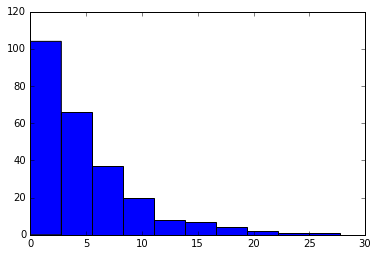

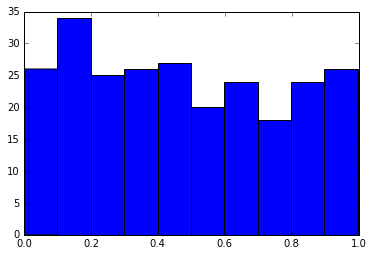

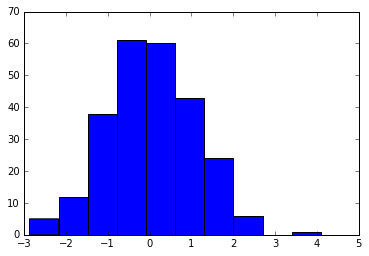

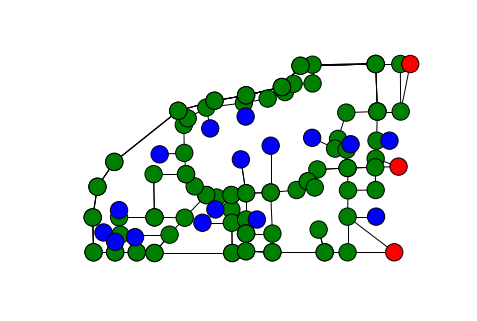

In [6]:
import csv
import math
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
from heapq import heappush, heappop, heapify

#Process the input file and return the rows of split data.
def processInput(inputFile):
    rows = []
    with open(inputFile) as f:
        c = csv.reader(f, delimiter=',')
        for row in c:
            rows.append(row)

    return rows[1:]

#Binary search for node in a list of nodes
def findNode(nodes, node, i, j):
    end = node.end
    if((j-i) == 1):
        if(nodes[i].start == end or nodes[j].start == end):
            #Check for left
            while(i >= 0 and nodes[i].start == end):
                node.addChildNode(nodes[i])
                i -= 1
            while(j < len(nodes) and nodes[j].start == end):
                node.addChildNode(nodes[j])
                j += 1
    else:
        n = int(math.ceil((j-i)/2.0)) + i
        if(nodes[n].start <= end):
            findNode(nodes, node, n, j)
        else:
            findNode(nodes, node, i, n)

#Graphing function to show the node connections
def showGraph(nodes):
    nodes = deepcopy(nodes)
    nodes = sorted(nodes, key=lambda node: node.id)
    G=nx.Graph()
    colors = []
    for node in nodes:
        children = node.getChildren()
        if(node.exit):
            G.add_node(node.id, pos=node.end)
            colors.append(EXIT_NODE_COLOR)
        else:
            G.add_node(node.id, pos=node.start)
            if(node.type == Node.TYPE_STREET):
                colors.append(STREET_NODE_COLOR)
            else:
                colors.append(PARKING_NODE_COLOR)
        for child in children:
            G.add_edge(node.id, child.id)
    pos=nx.get_node_attributes(G,'pos')
    pos=nx.spring_layout(G, pos=pos, fixed=pos.keys())
    plt.figure(4)
    nx.draw(G,pos,node_color=colors)
    plt.show()
    
#Init function that builds the world using the parsed rows
def buildGraph(rows):
    nodes = []
    i = 1
    for row in rows:
        assert(len(row) == 7)

        #Get node type, whether street or parking
        if(row[0] == 'Street'):
            nodeType = Node.TYPE_STREET
            capacity = int(math.sqrt((int(row[1]) - int(row[3])) ** 2 + (int(row[2]) - int(row[4])) ** 2) \
                * UNIT_LENGTH / AVERAGE_CAR_SPACE_LENGTH)
        elif(row[0] == 'Parking'):
            nodeType = Node.TYPE_PARKING
            capacity = int(row[5])
        else:
            raise Exception('Uknown type: ' + row[0])

        #Create node( type, (x1, x2), (y1, y2), capacity, id, comment)
        node = Node(nodeType, (int(row[1]), int(row[2])), (int(row[3]), int(row[4])), capacity, i, comment=row[6])
        nodes.append(node)

        #Set evcuation destinations
        if(node.end == (760,555) or node.end == (723,32) or node.end == (733,270)):
            node.setExit(True)

        #Create return path if not exit node and is a 2 way street
        if(row[0] == 'Street' and int(row[5]) == 2 and not node.exit):
            i += 1
            node = Node(nodeType, (int(row[3]), int(row[4])), (int(row[1]), int(row[2])), capacity, i, comment=row[6])
            nodes.append(node)

        i += 1
        #Set initial cars in parking lots
        if(nodeType == Node.TYPE_PARKING):
            for n in range(node.capacity):
                node.enterCar(Car(node))
    
    #Make node connections with its children.    
    nodes = sorted(nodes, key=lambda node: node.start)
    for node in nodes:
        findNode(nodes, node, 0, len(nodes) - 1)
    return nodes
def simulate():
    events = []
    #heappush (events, x_i)

def printDistribution():
    n = 250
    l = 5.0
    seed (20160224)
    e = [genRandom (l, type='exponential') for i in range (n)]
    u = [genRandom (l, type='uniform') for i in range (n)]
    g = [genRandom (l, type='normal') for i in range (n)]
    plt.figure(1)
    plt.hist (e)
    plt.show()
    plt.figure(2)
    plt.hist (u)
    plt.show()
    plt.figure(3)
    plt.hist (g)
    plt.show()

printDistribution()    
rows = processInput('world.csv')
nodes = buildGraph(rows)
showGraph(nodes)